# **Text Summarisation :Classical and Transformer Based Approaches**

##### This notebook is for the  implementation of text summarisation techniques by leveraging both transformer-based models and classical NLP approaches. The aim is to analyze and compare the effectiveness of advanced models like BERT and T5 with traditional techniques such as Bag of Words (BoW) and TF-IDF for text summarisation.ROGUE scores and Inference Times are used to measure the effectiveness of the models in this task

In [2]:
# Import Packages
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
import time
from nltk.util import ngrams

In [6]:
# Mount google drive for directory access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#load the data directories
train_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_train/cnn_train_data.csv')
test_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_test/cnn_test_data.csv')
val_data = pd.read_csv('/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/data/data_raw/data_validation/cnn_validation_data.csv')

### **Exploratory Data Analysis**

In this section, we analyze the  quality, and characteristics of the dataset to better understand the data and prepare it for modeling. EDA provides key insights into the dataset, identifies patterns, and helps uncover potential issues such as missing values, article and highlights length of the CNN/ Dailymail datset.

In [ ]:
#describe the dataset
train_data.describe()

,Unnamed: 0
count,95704.000000
mean,47851.500000
std,27627.509418
min,0.000000
25%,23925.750000
50%,47851.500000
75%,71777.250000
max,95703.000000


In [ ]:
# print the first 5 rows of train dataset
train_data.head(5)

,Unnamed: 0,article,highlights,id
0,0,By . Daily Mail Reporter . PUBLISHED: . 04:03 ...,Lackland Air Force Base instructor Christopher...,aaa6237fb3dabcc34f95ad010c15d90a55c769c4
1,1,"By . Martin Robinson . PUBLISHED: . 10:45 EST,...",Leanne Zaloumis was found by the music mogul s...,57fc39ad6aadaf215f7bbedf3f5947d93a3dec60
2,2,"By . Luke Salkeld . UPDATED: . 07:48 EST, 16 N...",One was posted from Paris - three days after G...,0fd3a209c873fb5229ea4d752f486645002c03f9
3,3,"By . Helen Collis . PUBLISHED: . 13:47 EST, 3 ...",Alex Shirra was unconscious for 12 days after ...,c53e85eca2140700b5c3a522ac34eddceeda73b4
4,4,"By . David Baker . PUBLISHED: . 13:54 EST, 2 A...",Firebombing comes after man stormed reception ...,4324f10606dca366e937dfcb1453c6a9d5364151


In [ ]:
# print missing values
missing_values = train_data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Unnamed: 0    0
article       0
highlights    0
id            0
dtype: int64


 The distribution of article lengths  is analysed here. The word count of each article is calculated by splitting the text into words, creating a new feature called article_length. A histogram is then plotted to visualize the frequency distribution of article lengths, with the x-axis representing the word count and the y-axis showing the frequency of articles within each range.

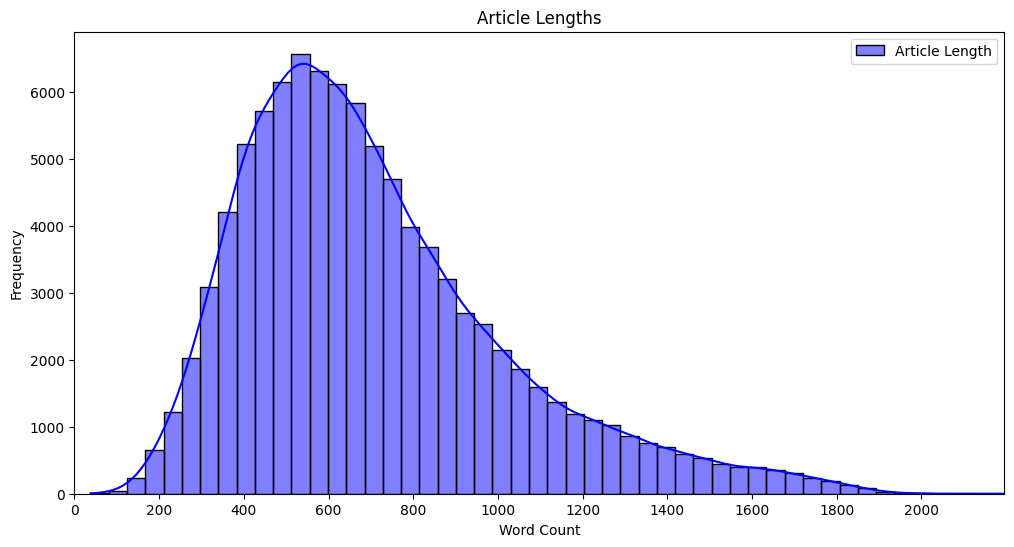

In [ ]:
#Length of Articles
train_data['article_length'] = train_data['article'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.histplot(train_data['article_length'], bins=50, kde=True, color='blue', label='Article Length')
plt.xticks(np.arange(0, train_data['article_length'].max() + 1, 200))
plt.xlim(0, train_data['article_length'].max() + 1)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.title("Article Lengths")
plt.show()

 The distribution of word counts in the highlights  is analysed here. The highlights_length feature is derived by calculating the word count of each highlight using a word-splitting function. A histogram is plotted to visualize the frequency distribution of the highlight lengths, with the x-axis representing the word count and the y-axis showing the frequency of highlights within each range.

Maximum word count in highlights: 1296


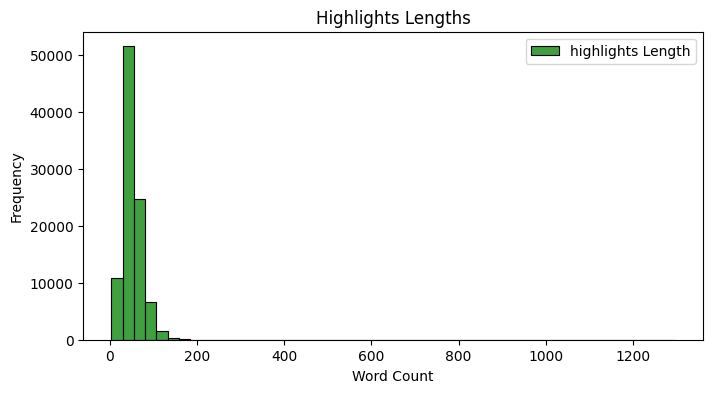

In [ ]:
# Length of Highlights
train_data['highlights_length'] = train_data['highlights'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,4))
sns.histplot(train_data['highlights_length'], bins=50, color='green',  label='highlights Length')
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.title("Highlights Lengths")
max_word_count = train_data['highlights_length'].max()
print("Maximum word count in highlights:", max_word_count)
plt.xticks(np.arange(0, max_word_count + 1, 200))
plt.show()

This section initializes text preprocessing by downloading the NLTK stopwords and punkt_tab resources. It then defines a set of English stopwords for filtering out common, non-informative words during text analysis.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


This section generates a word cloud to visualize the most frequent words in the dataset. By removing common stopwords using NLTK’s predefined list, the word cloud highlights the most meaningful and frequently occurring terms, providing an intuitive understanding of the dataset’s dominant themes and keywords.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


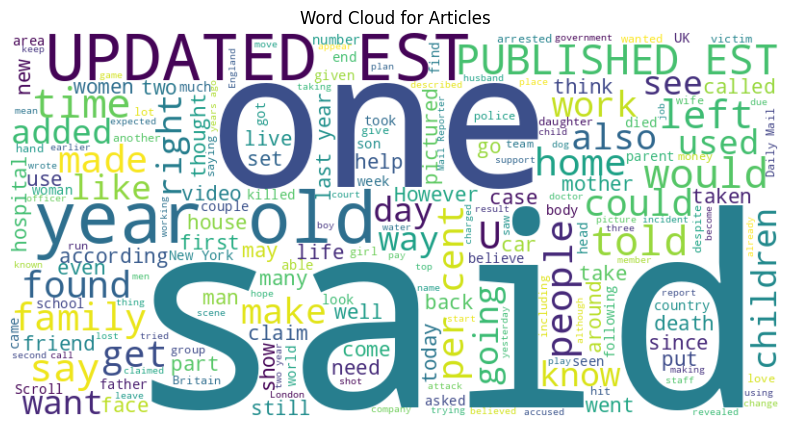

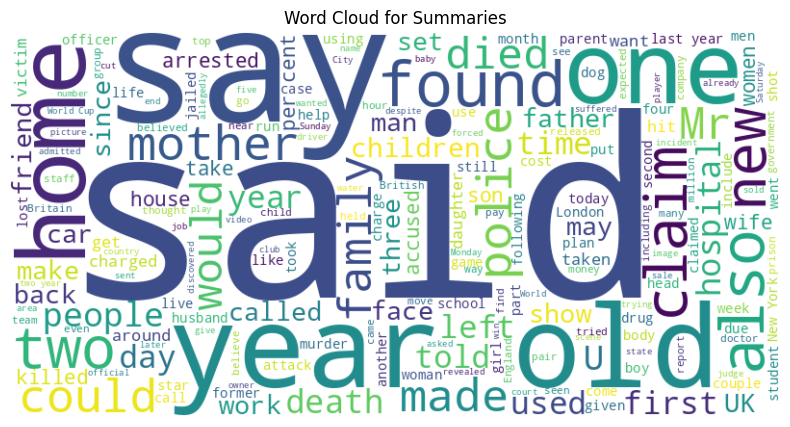

In [ ]:
def plot_wordcloud(text, title):
    '''
    This function creates a wordcloud for the given dataset.
    Input:
      text: list of strings
      title: title of the wordcloud
    Returns:
      Wordcloud of the given dataset
    '''
    wordcloud = WordCloud(width=800, height=400, stopwords=stop_words, background_color="white").generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

#Plot word clouds
plot_wordcloud(train_data['article'], 'Word Cloud for Articles')
plot_wordcloud(train_data['highlights'], 'Word Cloud for Summaries')

### **Data Preprocessing**

This section focuses on preparing the dataset for analysis and modeling. Key preprocessing steps include handling missing values, Lowercasing , removing non alphanumeric characters , Tokenisation and stop words removal.

In [8]:
# function to load  test dataset for classical approaches.
def load_cnn_daily_mail_dataset(csv_data):
    sample_df = test_data.sample(n=20, random_state=42)

    # Convert sample to a list of dictionaries with 'article' and 'highlights'
    data = sample_df[['article', 'highlights']].to_dict(orient='records')
    return data

 A single article is loaded from the dataset and the article along with its highlight is printed.

In [9]:
#load the dataset
data_samples = load_cnn_daily_mail_dataset(test_data)

#select one article from the dataset
example_article = data_samples[10]["article"]
original_summary = data_samples[10]["highlights"]

#print the article and summary
print("Original Article:", example_article)
print("Original Summary:", original_summary)

Original Article: Fenerbahce have called for the suspension of the Turkish championship following the gun attack on their team bus on Saturday. The bus came under armed attack as it drove to the airport following an away match at Caykur Rizespor in Turkey's Super Lig. Fener said on their official website the bus driver was wounded in the attack and taken to hospital and there was no mention of any injuries to anyone else. Marks can be seen on the windscreen of the Fenerbahce team bus after the attack . The window nearest the driver was smashed during the attack on Saturday night . The injured driver, with blood seeping from a head wound, seeks help  after the attack . A statement on the club's official website on Sunday said: 'We consider that as long as this attack is not solved in a way that satisfies Fenerbahce and public opinion, a suspension of the championship is inevitable. 'Blood ran and football was silenced. Finding and punishing the culprits is of vital importance for Fenerb

Natural Language Toolkit (NLTK) resources are downloaded to support text preprocessing tasks. The stopwords dataset is used to identify and filter out common English words that do not contribute meaningful information for text analysis. Additionally, the punkt_tab resource is downloaded to support tokenization tasks. A set of English stopwords is then initialized using the stopwords.words method, which will be used in subsequent steps to clean and preprocess the text data effectively.

In [10]:
# Download NLTK stopwords
nltk.download("stopwords")
nltk.download('punkt_tab')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


 preprocess_text function  is used to clean and preprocess the text data. It starts by converting the entire text to lowercase, ensuring consistency and avoiding case-sensitive issues. Non-alphanumeric characters are removed using regular expressions, leaving only relevant words and spaces. The function then splits the text into individual words (tokens) and filters out common stopwords, using a predefined list of English stopwords. Finally, the cleaned tokens are joined back together into a single string.

In [11]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    # Removing stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

Here an example articles is preprocessed and its output is printed

In [12]:
#example preprocessed article
preprocessed_article = preprocess_text(example_article)
print("Preprocessed Article:", preprocessed_article)

#example preprocessed highlight
preprocessed_summary = preprocess_text(original_summary)
print("Preprocessed Summary:", preprocessed_summary)

Preprocessed Article: fenerbahce called suspension turkish championship following gun attack team bus saturday bus came armed attack drove airport following away match caykur rizespor turkey super lig fener said official website bus driver wounded attack taken hospital mention injuries anyone else marks seen windscreen fenerbahce team bus attack window nearest driver smashed attack saturday night injured driver blood seeping head wound seeks help attack statement club official website sunday said consider long attack solved way satisfies fenerbahce public opinion suspension championship inevitable blood ran football silenced finding punishing culprits vital importance fenerbahce following incident fener midfielder mehmet topal told sky news cheated death god protect us hope driver right words fail unbelievable club posted several pictures bus website attack showed shattered side window damage front windscreen players coaching staff survey damage attack near city trabzon fenerbahce coac

In [13]:
# Dictionary to store inference time of models
Inference_time={}

###  **Bag of Words**

Bag of Words (BoW) is a text representation technique that converts a collection of text into a matrix of word frequencies. It disregards grammar and word order but focuses on the occurrence of words in the text. Each document is represented as a vector where the value corresponds to the frequency or presence of words from a predefined vocabulary. BoW is commonly used for text classification and information retrieval tasks.

In [42]:
# Function tp summarize with BoW
def summarize_with_bow(article_text, num_sentences=2):

    '''
      This function summarises the given articles with BoW method
      Args:
        article_text: str
        num_sentences: int
      Returns:
         summary of the article
    '''

    # Split article into sentences and preprocess it
    sentences = nltk.sent_tokenize(article_text)
    processed_sentences = [preprocess_text(sentence) for sentence in sentences]

    # Vectorize sentences using Bag of Words
    vectorizer = CountVectorizer()
    sentence_vectors = vectorizer.fit_transform(processed_sentences)

    # Compute similarity score
    similarity_matrix = cosine_similarity(sentence_vectors)
    sentence_scores = similarity_matrix.sum(axis=1)
    ranked_sentences = np.argsort(sentence_scores)[::-1]

    # Select top sentences
    selected_sentences = [sentences[i] for i in ranked_sentences[:num_sentences]]
    summary = " ".join(selected_sentences)
    return summary


In [43]:
# Generate summary for an example article
summary = summarize_with_bow(example_article)
print("Generated Summary:", summary)

Generated Summary: Fenerbahce have called for the suspension of the Turkish championship following the gun attack on their team bus on Saturday. Marks can be seen on the windscreen of the Fenerbahce team bus after the attack .


In [44]:
def Calculate_Rouge_Bow(val_data):

    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Sample the validation data
    sample = val_data.sample(25, random_state=30)

    # Initialize storage for precision, recall, and fmeasure
    rouge1_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rouge2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rougeL_scores = {'precision': [], 'recall': [], 'fmeasure': []}

    # Calculate ROUGE scores for each sample
    for _, row in sample.iterrows():
        original_summary = row['highlights']
        bow_summary = summarize_with_bow(row['article'])
        scores = scorer.score(original_summary, bow_summary)

        # Append precision, recall, and fmeasure for each metric
        rouge1_scores['precision'].append(scores['rouge1'].precision)
        rouge1_scores['recall'].append(scores['rouge1'].recall)
        rouge1_scores['fmeasure'].append(scores['rouge1'].fmeasure)

        rouge2_scores['precision'].append(scores['rouge2'].precision)
        rouge2_scores['recall'].append(scores['rouge2'].recall)
        rouge2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

        rougeL_scores['precision'].append(scores['rougeL'].precision)
        rougeL_scores['recall'].append(scores['rougeL'].recall)
        rougeL_scores['fmeasure'].append(scores['rougeL'].fmeasure)

    # Compute average precision, recall, and fmeasure for each metric
    BoW_avg_scores = {
        'ROUGE-1': {
            'precision': np.mean(rouge1_scores['precision']),
            'recall': np.mean(rouge1_scores['recall']),
            'fmeasure': np.mean(rouge1_scores['fmeasure']),
        },
        'ROUGE-2': {
            'precision': np.mean(rouge2_scores['precision']),
            'recall': np.mean(rouge2_scores['recall']),
            'fmeasure': np.mean(rouge2_scores['fmeasure']),
        },
        'ROUGE-L': {
            'precision': np.mean(rougeL_scores['precision']),
            'recall': np.mean(rougeL_scores['recall']),
            'fmeasure': np.mean(rougeL_scores['fmeasure']),
        },
    }

    return BoW_avg_scores

In [45]:
# Calculate inference time fot BoW
start_time = time.time()
Bow_summary = summarize_with_bow(example_article)
end_time = time.time()
Inference_time['BoW'] = end_time - start_time
print(f"Time taken: {end_time - start_time} seconds")

#Calculate Average ROUGE score
avg_BoW_Rouge = Calculate_Rouge_Bow(val_data)
print(avg_BoW_Rouge)

Time taken: 0.004717350006103516 seconds
{'ROUGE-1': {'precision': 0.37328232795494437, 'recall': 0.31811280102659106, 'fmeasure': 0.3281739983034096}, 'ROUGE-2': {'precision': 0.12449009341442549, 'recall': 0.1160184876414799, 'fmeasure': 0.11581793862083296}, 'ROUGE-L': {'precision': 0.23657691426129862, 'recall': 0.20467201315119785, 'fmeasure': 0.20930036314774353}}


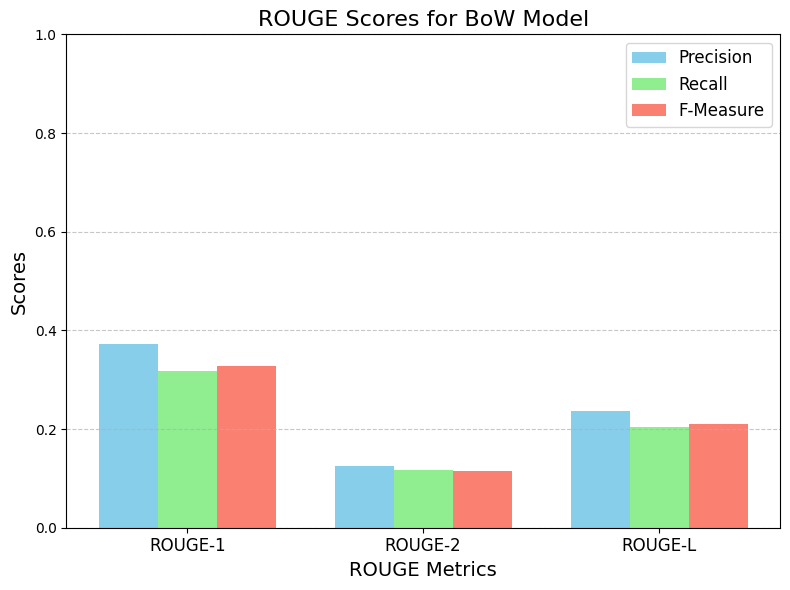

In [46]:
def plot_rouge_BoW(rouge_scores):

    '''
      This function plots the roue scores for BoW model
      Args:
        rouge_scores: dict
      Returns:
        plot of the rouge scores
    '''

    # ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Extract precision, recall, and fmeasure scores
    precision = [rouge_scores[metric]['precision'] for metric in metrics]
    recall = [rouge_scores[metric]['recall'] for metric in metrics]
    fmeasure = [rouge_scores[metric]['fmeasure'] for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for BoW Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_rouge_BoW(avg_BoW_Rouge)

### **TF - IDF**

TF-IDF (Term Frequency-Inverse Document Frequency) is a statistical method used in Natural Language Processing (NLP) to evaluate the importance of a word in a document relative to a collection of documents (corpus). It combines two metrics:

	1. Term Frequency (TF): Measures how often a word appears in a document.

	2. Inverse Document Frequency (IDF): Measures how unique a word is across all documents in the corpus.

  The final TF-IDF score is calculated as: TF-IDF = TF*IDF

Words that occur frequently in a document but rarely across the corpus will have a high TF-IDF score, making this method effective for identifying keywords and features for text analysis tasks.

In [14]:
#Function to summarise with TF-IDF
def summarize_with_tfidf(article_text, num_sentences=2):
    # Split article into sentences
    sentences = nltk.sent_tokenize(article_text)
    # Preprocess sentences
    processed_sentences = [preprocess_text(sentence) for sentence in sentences]

    # Vectorize sentences using TF-IDF
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(processed_sentences)

    # similarity matrix
    similarity_matrix = cosine_similarity(sentence_vectors)

    # Rank sentences by similarity scores
    sentence_scores = similarity_matrix.sum(axis=1)
    ranked_sentences = np.argsort(sentence_scores)[::-1]

    # Select top sentences
    selected_sentences = [sentences[i] for i in ranked_sentences[:num_sentences]]
    summary = " ".join(selected_sentences)
    return summary

# Generate summary
summary = summarize_with_tfidf(example_article)
print("Generated Summary:", summary)

Generated Summary: Fenerbahce have called for the suspension of the Turkish championship following the gun attack on their team bus on Saturday. The club posted several pictures of the bus on their website after the attack which showed a shattered side window and damage to the front windscreen.


In [15]:
def Calculate_Rouge_TF_IDF(val_data):

    '''
    This function Calculates the Rouge scores for TF-IDF model
    Args:
      val_data: validation dataset
    Returns:
      Rouge scores for TF-IDF model
    '''

    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Sample the validation data
    sample = val_data.sample(25, random_state=30)

    # Initialize storage for precision, recall, and fmeasure
    rouge1_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rouge2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rougeL_scores = {'precision': [], 'recall': [], 'fmeasure': []}

    # Calculate ROUGE scores for each sample
    for _, row in sample.iterrows():
        original_summary = row['highlights']
        TFIDF_summary = summarize_with_tfidf(row['article'])
        scores = scorer.score(original_summary, TFIDF_summary)

        # Append precision, recall, and fmeasure for each metric
        rouge1_scores['precision'].append(scores['rouge1'].precision)
        rouge1_scores['recall'].append(scores['rouge1'].recall)
        rouge1_scores['fmeasure'].append(scores['rouge1'].fmeasure)

        rouge2_scores['precision'].append(scores['rouge2'].precision)
        rouge2_scores['recall'].append(scores['rouge2'].recall)
        rouge2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

        rougeL_scores['precision'].append(scores['rougeL'].precision)
        rougeL_scores['recall'].append(scores['rougeL'].recall)
        rougeL_scores['fmeasure'].append(scores['rougeL'].fmeasure)

    # Compute average precision, recall, and fmeasure for each metric
    TFIDF_avg_scores = {
        'ROUGE-1': {
            'precision': np.mean(rouge1_scores['precision']),
            'recall': np.mean(rouge1_scores['recall']),
            'fmeasure': np.mean(rouge1_scores['fmeasure']),
        },
        'ROUGE-2': {
            'precision': np.mean(rouge2_scores['precision']),
            'recall': np.mean(rouge2_scores['recall']),
            'fmeasure': np.mean(rouge2_scores['fmeasure']),
        },
        'ROUGE-L': {
            'precision': np.mean(rougeL_scores['precision']),
            'recall': np.mean(rougeL_scores['recall']),
            'fmeasure': np.mean(rougeL_scores['fmeasure']),
        },
    }

    return TFIDF_avg_scores

In [16]:
#Calculate Inference Time
start_time = time.time()
TF_IDF_summary = summarize_with_tfidf(example_article)
end_time = time.time()
Inference_time['TF-IDF'] = end_time - start_time
print(f"Time taken: {end_time - start_time} seconds")

#calculate Average Rouge score
avg_TFIDF_Rouge = Calculate_Rouge_TF_IDF(val_data)
print(avg_TFIDF_Rouge)

Time taken: 0.00700688362121582 seconds
{'ROUGE-1': {'precision': 0.3676054821300049, 'recall': 0.32879906501647305, 'fmeasure': 0.33278928044454587}, 'ROUGE-2': {'precision': 0.1357038204270968, 'recall': 0.1238489814560993, 'fmeasure': 0.1246286840872904}, 'ROUGE-L': {'precision': 0.23582132786341528, 'recall': 0.21579639717975085, 'fmeasure': 0.2160152739158595}}


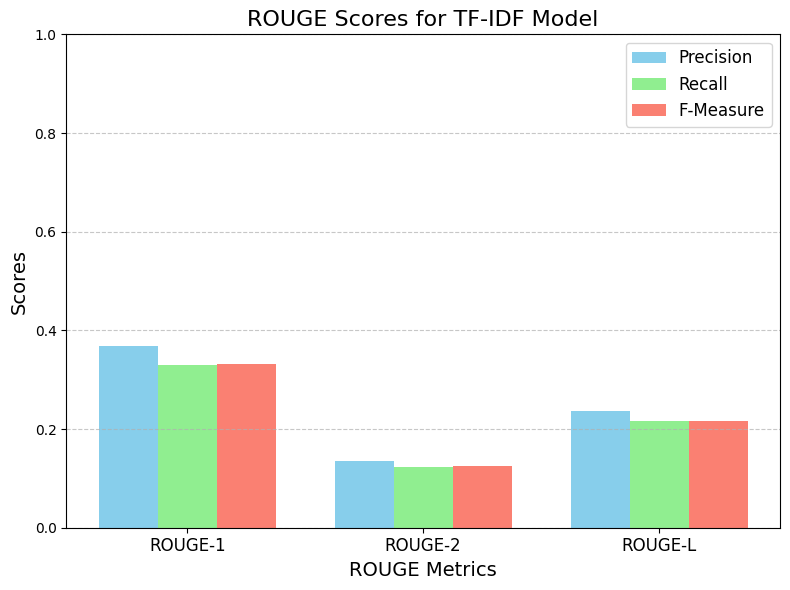

In [ ]:
def plot_rouge_TFIDF(rouge_scores):

    # ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Extract precision, recall, and fmeasure scores
    precision = [rouge_scores[metric]['precision'] for metric in metrics]
    recall = [rouge_scores[metric]['recall'] for metric in metrics]
    fmeasure = [rouge_scores[metric]['fmeasure'] for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for TF-IDF Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
# Assuming `avg_scores` is the output of `Calculate_Rouge_Bow`
plot_rouge_TFIDF(avg_TFIDF_Rouge)

### **T5 (Text-to-Text Transfer Transformer)**

The T5  is a powerful transformer model developed by Google Research, which simplifies natural language processing (NLP) tasks by converting them into a text-to-text format. This unified approach enables T5 to handle diverse tasks, such as summarization, translation etc


In [17]:
#Import Libraries
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate
import numpy as np

The CNN/Daily Mail dataset is loaded to perform text summarization tasks. A subset of the dataset is created by sampling the first 30,000 instances from the training set to optimize for computational efficiency. This sampled dataset is then split into training and test sets, with 80% used for training and 20% for testing. Additionally, the T5 tokenizer is initialized using the “t5-small” checkpoint to preprocess the text data for the model.

In [18]:
%%capture
cnn_dailymail = load_dataset("cnn_dailymail", "1.0.0")
sampled_dataset = cnn_dailymail["train"].select(range(30000))
cnn_dailymail = sampled_dataset.train_test_split(test_size=0.2)
checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

The preprocess_function prepares the dataset for model training by prefixing each article with “summarize: “ to guide the model’s summarization task. It tokenizes the input articles and the corresponding summaries while applying truncation and padding to ensure the sequences are of appropriate length. The tokenized summaries are added as labels to the model inputs, ready for training.

In [19]:
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)
    labels = tokenizer(text_target=examples["highlights"], max_length=128, truncation=True,padding=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

The dataset is tokenized using the preprocess_function with batching enabled. A DataCollatorForSeq2Seq is created to handle padding and batching during training, using the T5 tokenizer and model checkpoint. The ROUGE metric is loaded to evaluate model performance on summarization tasks. Finally, the T5 model is loaded from the pre-trained “t5-small” checkpoint, ready for fine-tuning on the dataset.

In [21]:
tokenized_cnn_dailymail = cnn_dailymail.map(preprocess_function, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)
rouge = evaluate.load("rouge")
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The compute_metrics function is used to evaluate the performance of a text generation model, It takes eval_pred as input, which contains the model’s predicted outputs and the true labels. The predictions and labels are then decoded from token IDs to human-readable text using the tokenizer.batch_decode function, skipping any special tokens like padding. Any padding tokens in the labels are replaced with the tokenizer’s padding token ID to ensure proper handling.

In [20]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    print("Sample Predictions:", decoded_preds[:3])  # Log some predictions
    return {k: round(v, 4) for k, v in result.items()}

  This section  defines the training parameters with Seq2SeqTrainingArguments, where key settings include the output directory for model checkpoints, evaluation frequency set to occur after each epoch, and a learning rate of 2e-5. The batch size for both training and evaluation is set to 8, and weight decay is applied with a value of 0.01 to help prevent overfitting. The model is trained for 3 epochs, and the number of saved checkpoints is limited to 3. The predict_with_generate argument is set to True, allowing the model to generate predictions during evaluation, and fp16 is enabled for mixed precision training, which helps speed up training and reduce memory usage. The Seq2SeqTrainer is then initialized with the model, training arguments, tokenized datasets, tokenizer, data collator, and a custom metric function (compute_metrics). Finally, the training process is executed using trainer.train().

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/models",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,

)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_cnn_dailymail["train"],
    eval_dataset=tokenized_cnn_dailymail["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,

)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-26-369e122fd70e>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.109700,1.019239,0.239200,0.099300,0.193000,0.193100,19.953300
2,1.090800,1.012629,0.240600,0.100400,0.194600,0.194700,19.990000
3,1.085200,1.011719,0.240200,0.100200,0.194600,0.194600,19.996700


Sample Predictions: ['The kids and I made history this summer. They decided to go to Savannah, Georgia, and', 'NEW: The National Hurricane Center warns of tall structures in Hurricane Irene. Winds', 'Italian mobster Luciano Aviello says he can prove Knox innocent. Aviello']
Sample Predictions: ['Savannah, 11, and Camron, 12, decided on itineraries for their summer trips.', 'NEW: The National Hurricane Center warns of tall structures in Hurricane Irene. NEW:', 'Italian mobster Luciano Aviello says he can prove Knox innocent. Aviello']
Sample Predictions: ['Savannah, 11, and Camron, 12, decided on itineraries for their summer trips.', 'NEW: The National Hurricane Center warns of tall structures in Hurricane Irene. NEW:', 'Italian mobster Luciano Aviello says he can prove Knox innocent. Aviello']


TrainOutput(global_step=9000, training_loss=1.1392581990559896, metrics={'train_runtime': 4221.3928, 'train_samples_per_second': 17.056, 'train_steps_per_second': 2.132, 'total_flos': 1.938037711228109e+16, 'train_loss': 1.1392581990559896, 'epoch': 3.0})

Hyperparameter tuning using Optuna

In [ ]:
# import optuna
# from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
# from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
# from datasets import load_dataset
# from sklearn.model_selection import train_test_split
# import torch

# # Load the CNN/Daily Mail dataset
# dataset = load_dataset("cnn_dailymail", "1.0.0")

# # Prepare the dataset
# def preprocess_data(examples):
#     tokenizer = T5Tokenizer.from_pretrained("t5-small")
#     inputs = ["summarize: " + doc for doc in examples["article"]]
#     model_inputs = tokenizer(inputs, max_length=512, truncation=True)

#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer(examples["highlights"], max_length=150, truncation=True)

#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

# tokenizer = T5Tokenizer.from_pretrained("t5-small")
# tokenized_dataset = dataset.map(preprocess_data, batched=True)

# # Split dataset into train and validation sets
# train_data = tokenized_dataset["train"].shuffle(seed=42).select(range(1000))  #  subset for testing
# val_data = tokenized_dataset["validation"].shuffle(seed=42).select(range(500))  #Small subset for testing

# # Optuna objective function
# def objective(trial):
#     # Suggest hyperparameters
#     learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 5e-4)
#     batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])
#     num_beams = trial.suggest_int("num_beams", 2, 8)
#     num_train_epochs = trial.suggest_int("num_train_epochs", 1, 5)

#     # Load model
#     model = T5ForConditionalGeneration.from_pretrained("t5-small")

#     # Define training arguments
#     training_args = Seq2SeqTrainingArguments(
#         output_dir="./results",
#         evaluation_strategy="epoch",
#         learning_rate=learning_rate,
#         per_device_train_batch_size=batch_size,
#         per_device_eval_batch_size=batch_size,
#         num_train_epochs=num_train_epochs,
#         predict_with_generate=True,
#         save_strategy="no",
#         logging_dir="./logs",
#         logging_steps=100,
#         do_train=True,
#         do_eval=True,
#     )

#     # Data collator
#     data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

#     # Define Trainer
#     trainer = Seq2SeqTrainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_data,
#         eval_dataset=val_data,
#         tokenizer=tokenizer,
#         data_collator=data_collator,
#     )

#     # Train and evaluate
#     trainer.train()
#     metrics = trainer.evaluate()

#     # Use ROUGE-L as the optimization metric
#     return metrics["eval_rougeL"]

# # Create and run Optuna study
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)

# # Print the best trial
# print("Best trial:")
# print(f"  Value (ROUGE-L): {study.best_trial.value}")
# print(f"  Params: {study.best_trial.params}")

The model is loaded from the checkpoint from the saved directory and a tokenizer is initilized using AutoTokenizer

In [22]:
model_name = "/content/drive/Othercomputers/My Mac/DS-Project/text_summarization_project/models/checkpoint-9000" #loading the model checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [23]:
#Print model
print(model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [24]:
# Function to summarise with T5
def summerize_with_T5(article_text):
    '''
    This function summarises the article with T5
    args:
      article_text: article to be summarised
    returns:
      summary: summarised article
    '''
    inputs = tokenizer(article_text, return_tensors="pt", max_length=1024, truncation=True)
    start_time = time.time()
    outputs = model.generate(
          **inputs,
          max_length=1024,
          early_stopping=True,
          temperature=0.8,
          top_k=70,
          top_p=0.8,
          num_beams=4,
      )
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

In [25]:
# Function to calculate rouge score
def Calculate_Rouge_T5(val_data):

    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Sample the validation data
    sample = val_data.sample(25, random_state=30)

    # Initialize storage for precision, recall, and fmeasure
    rouge1_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rouge2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rougeL_scores = {'precision': [], 'recall': [], 'fmeasure': []}

    # Calculate ROUGE scores for each sample
    for _, row in sample.iterrows():
        original_summary = row['highlights']
        T5_summary = summerize_with_T5(row['article'])
        scores = scorer.score(original_summary, T5_summary)

        # Append precision, recall, and fmeasure for each metric
        rouge1_scores['precision'].append(scores['rouge1'].precision)
        rouge1_scores['recall'].append(scores['rouge1'].recall)
        rouge1_scores['fmeasure'].append(scores['rouge1'].fmeasure)

        rouge2_scores['precision'].append(scores['rouge2'].precision)
        rouge2_scores['recall'].append(scores['rouge2'].recall)
        rouge2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

        rougeL_scores['precision'].append(scores['rougeL'].precision)
        rougeL_scores['recall'].append(scores['rougeL'].recall)
        rougeL_scores['fmeasure'].append(scores['rougeL'].fmeasure)

    # Compute average precision, recall, and fmeasure for each metric
    T5_avg_scores = {
        'ROUGE-1': {
            'precision': np.mean(rouge1_scores['precision']),
            'recall': np.mean(rouge1_scores['recall']),
            'fmeasure': np.mean(rouge1_scores['fmeasure']),
        },
        'ROUGE-2': {
            'precision': np.mean(rouge2_scores['precision']),
            'recall': np.mean(rouge2_scores['recall']),
            'fmeasure': np.mean(rouge2_scores['fmeasure']),
        },
        'ROUGE-L': {
            'precision': np.mean(rougeL_scores['precision']),
            'recall': np.mean(rougeL_scores['recall']),
            'fmeasure': np.mean(rougeL_scores['fmeasure']),
        },
    }

    return T5_avg_scores

In [27]:
# Calculate Inference time
start_time = time.time()
T5_Summary = summerize_with_T5(example_article)
print(T5_Summary)
end_time = time.time()
Inference_time['T5'] = end_time - start_time
print(f"Time taken: {end_time - start_time} seconds")

# Print Rouge Scores
avg_T5_rouge = Calculate_Rouge_T5(val_data)
print(avg_T5_rouge)

Fenerbahce have called for the suspension of the Turkish championship. The club posted several pictures of the team bus on their website. The bus came under armed attack as it drove to the airport. The bus came under armed attack as it drove to the airport.
Time taken: 1.5101547241210938 seconds
{'ROUGE-1': {'precision': 0.39319730956752297, 'recall': 0.41109046467524707, 'fmeasure': 0.38991900301098215}, 'ROUGE-2': {'precision': 0.16341241301564977, 'recall': 0.16605474966366043, 'fmeasure': 0.1600659598510088}, 'ROUGE-L': {'precision': 0.26041869758801395, 'recall': 0.27611052998064517, 'fmeasure': 0.25939456580283443}}


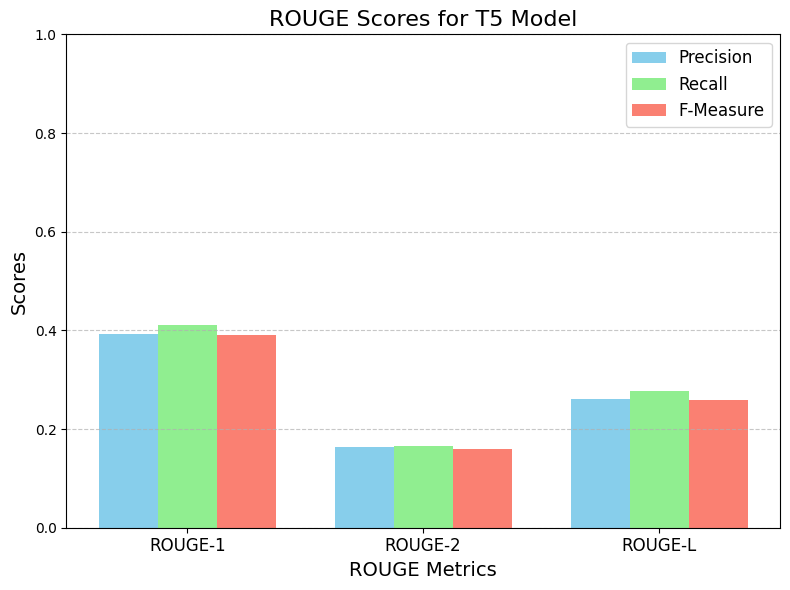

In [28]:
#Function to plot rouge score
def plot_rouge_T5(rouge_scores):

    # ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Extract precision, recall, and fmeasure scores
    precision = [rouge_scores[metric]['precision'] for metric in metrics]
    recall = [rouge_scores[metric]['recall'] for metric in metrics]
    fmeasure = [rouge_scores[metric]['fmeasure'] for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for T5 Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_rouge_T5(avg_T5_rouge)

### **BERT - Bidirectional Encoder Representations From Transformers**

BERT  is a transformer-based model that has revolutionized the field NLP by leveraging its bidirectional architecture to capture contextual relationships between words from both the left and right sides of a token. This unique ability makes BERT highly effective for a variety of NLP tasks, including text summarization, where understanding the context is crucial. In this project,  BERT2BERT, a variation of BERT tailored for text-to-text tasks, is explored to perform abstractive summarization. While BERT excels at understanding text, BERT2BERT leverages the encoder-decoder framework to generate fluent and concise summaries by rewriting the content.

In [29]:
#Import Libraries
%%capture
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

#load the model checkpoints from HuggingFace
tokenizer = AutoTokenizer.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")
model = AutoModelForSeq2SeqLM.from_pretrained("patrickvonplaten/bert2bert_cnn_daily_mail")

Config of the encoder: <class 'transformers.models.bert.modeling_bert.BertModel'> is overwritten by shared encoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "return_dict": false,
  "transformers_version": "4.47.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Config of the decoder: <class 'transformers.models.bert.modeling_bert.BertLMHeadModel'> is overwritten by shared decoder config: BertConfig {
  "_name_or_path": "bert-base-uncased",
  "add_cross_attention"

In [31]:
%%capture
# Implement BERT2BERT model
from transformers import EncoderDecoderModel
bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.e

In [33]:
def summerize_with_BERT(article_text):
    '''
      This function summarises the article with BERT
      args:
        article_text: article to be summarised
      returns:
        summary: summarised article
      '''

    # Tokenize the input article
    inputs = tokenizer(article_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length")
    device = next(model.parameters()).device  # Get model's device
    inputs = inputs.to(device)

    # set the decoder_start_token_id
    if model.config.decoder_start_token_id is None:
        model.config.decoder_start_token_id = tokenizer.cls_token_id

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=150,          # Max length of the generated summary
        num_beams=4,             # Beam search for quality improvement
        length_penalty=2.0,      # shorter summaries
        no_repeat_ngram_size=3,  # Avoid repetition
        early_stopping=True,
    )

    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [34]:
def Calculate_Rouge_BERT(val_data):

    '''
    This function calculates the ROUGE scores for BERT
    args:
      val_data: validation data
    returns:
      BERT_avg_scores: average ROUGE scores for BERT
    '''
    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Sample the validation data
    sample = val_data.sample(25, random_state=30)

    # Initialize storage for precision, recall, and fmeasure
    rouge1_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rouge2_scores = {'precision': [], 'recall': [], 'fmeasure': []}
    rougeL_scores = {'precision': [], 'recall': [], 'fmeasure': []}

    # Calculate ROUGE scores for each sample
    for _, row in sample.iterrows():
        original_summary = row['highlights']
        BERT_summary = summerize_with_BERT(row['article'])
        scores = scorer.score(original_summary, BERT_summary)

        # Append precision, recall, and fmeasure for each metric
        rouge1_scores['precision'].append(scores['rouge1'].precision)
        rouge1_scores['recall'].append(scores['rouge1'].recall)
        rouge1_scores['fmeasure'].append(scores['rouge1'].fmeasure)

        rouge2_scores['precision'].append(scores['rouge2'].precision)
        rouge2_scores['recall'].append(scores['rouge2'].recall)
        rouge2_scores['fmeasure'].append(scores['rouge2'].fmeasure)

        rougeL_scores['precision'].append(scores['rougeL'].precision)
        rougeL_scores['recall'].append(scores['rougeL'].recall)
        rougeL_scores['fmeasure'].append(scores['rougeL'].fmeasure)

    # Compute average precision, recall, and fmeasure for each metric
    BERT_avg_scores = {
        'ROUGE-1': {
            'precision': np.mean(rouge1_scores['precision']),
            'recall': np.mean(rouge1_scores['recall']),
            'fmeasure': np.mean(rouge1_scores['fmeasure']),
        },
        'ROUGE-2': {
            'precision': np.mean(rouge2_scores['precision']),
            'recall': np.mean(rouge2_scores['recall']),
            'fmeasure': np.mean(rouge2_scores['fmeasure']),
        },
        'ROUGE-L': {
            'precision': np.mean(rougeL_scores['precision']),
            'recall': np.mean(rougeL_scores['recall']),
            'fmeasure': np.mean(rougeL_scores['fmeasure']),
        },
    }

    return BERT_avg_scores

In [36]:
#Calculate Inference Time
start_time = time.time()
BERT_Summary =  summerize_with_BERT(example_article)
print(BERT_Summary)
end_time = time.time()
Inference_time['BERT'] = end_time - start_time
print(f"Time taken: {end_time - start_time} seconds")

# Print Rouge Score
avg_BERT_rouge = Calculate_Rouge_BERT(val_data)

fenerbahce have called for the suspension of the turkish championship. the bus came under armed attack as it drove to the airport. the incident followed an away match at caykur rizespor in turkey's super lig. turkish football federation said the attack was'very wrong '
Time taken: 3.8921926021575928 seconds


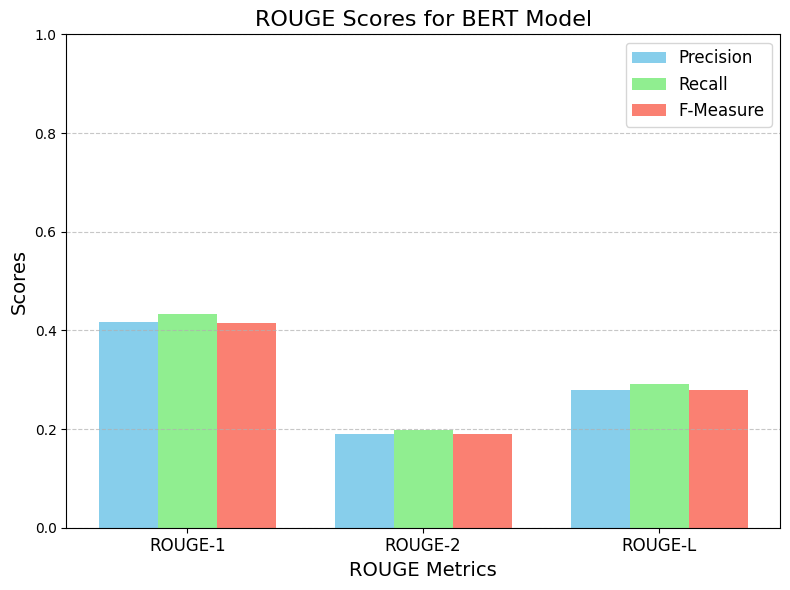

In [39]:
def plot_rouge_BERT(rouge_scores):
    '''
    This function plots the ROUGE scores for BERT
    args:
      rouge_scores: ROUGE scores for BERT
    returns:
      plot of ROUGE scores for BERT
    '''

    # ROUGE metrics
    metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

    # Extract precision, recall, and fmeasure scores
    precision = [rouge_scores[metric]['precision'] for metric in metrics]
    recall = [rouge_scores[metric]['recall'] for metric in metrics]
    fmeasure = [rouge_scores[metric]['fmeasure'] for metric in metrics]

    # Set up the bar width and positions
    bar_width = 0.25
    x = np.arange(len(metrics))  # Positions for the bars

    # Plot the bars
    plt.figure(figsize=(8, 6))
    plt.bar(x - bar_width, precision, width=bar_width, label='Precision', color='skyblue')
    plt.bar(x, recall, width=bar_width, label='Recall', color='lightgreen')
    plt.bar(x + bar_width, fmeasure, width=bar_width, label='F-Measure', color='salmon')

    # Add labels and title
    plt.xticks(x, metrics, fontsize=12)
    plt.xlabel("ROUGE Metrics", fontsize=14)
    plt.ylabel("Scores", fontsize=14)
    plt.title("ROUGE Scores for BERT Model", fontsize=16)
    plt.legend(fontsize=12)
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()
plot_rouge_BERT(avg_BERT_rouge)

### **Performance Evaluation**

The performance of the text summarization models is evaluated using established metrics commonly used in the NLP community. In this project, we focus on the ROUGE  metrics, which are widely used to assess the quality of automatic summaries by comparing them to reference summaries. ROUGE scores, specifically ROUGE-1, ROUGE-2, and ROUGE-L, are used to evaluate unigrams, bigrams, and the longest common subsequences between the generated summaries and the human-written reference summaries. Additionally, we compare the performance of different summarization models, including TF-IDF , BoW , T5 and BERT. By analyzing the ROUGE scores, we can determine which approach produces summaries that best reflect the key content and structure of the original text.

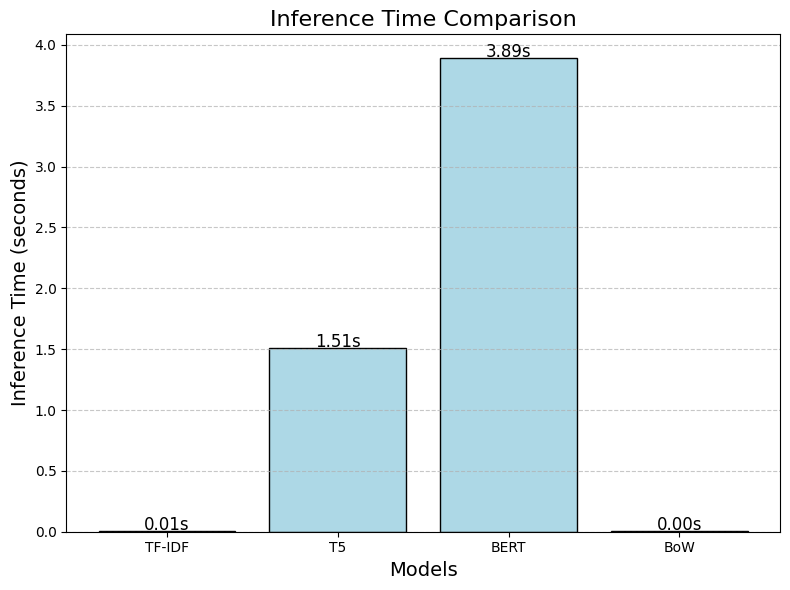

In [49]:
def plot_inference_times_from_dict(inference_times_dict):

    '''
    This function plots the inference times for each model
    args:
      inference_times_dict: dictionary of inference times for each model
    returns:
      plot of inference times for each model
    '''
    models = list(inference_times_dict.keys())
    inference_times = list(inference_times_dict.values())

    # Create the bar chart
    plt.figure(figsize=(8, 6))
    plt.bar(models, inference_times, color='lightblue', edgecolor='black')

    # Add titles and labels
    plt.title("Inference Time Comparison", fontsize=16)
    plt.xlabel("Models", fontsize=14)
    plt.ylabel("Inference Time (seconds)", fontsize=14)

    # Annotate the bars with the actual inference times
    for i, time in enumerate(inference_times):
        plt.text(i, time + 0.01, f"{time:.2f}s", ha='center', fontsize=12)

    # Customize the grid and layout
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_inference_times_from_dict(Inference_time)

[0.3281739983034096, 0.33278928044454587, 0.38991900301098215, 0.41492694972382355]


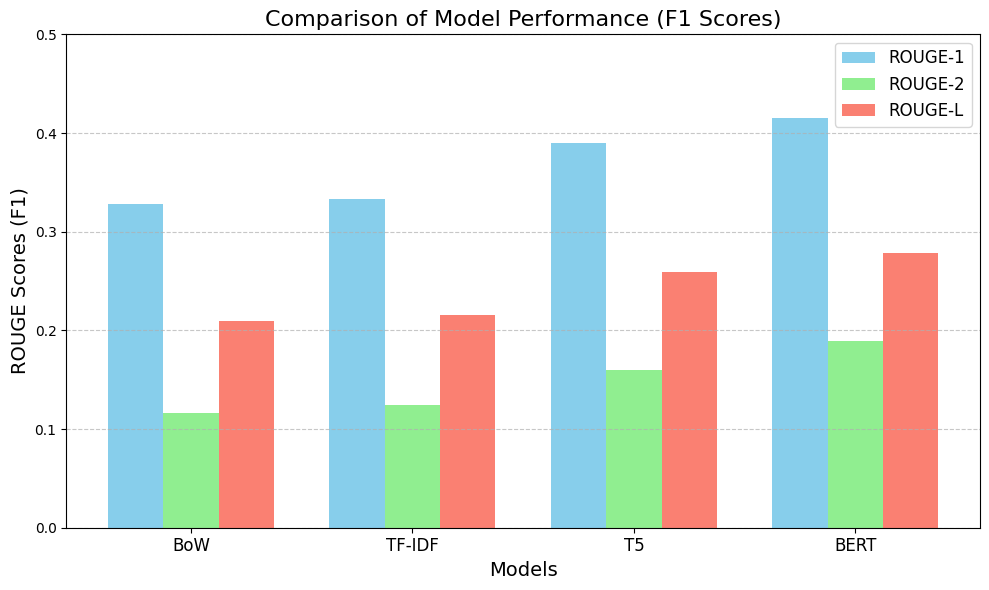

In [47]:
import matplotlib.pyplot as plt
import numpy as np

'''
This function plots the F1 scores for each model
args:
  avg_BoW_Rouge: ROUGE scores for BoW
  avg_TFIDF_Rouge: ROUGE scores for TF-IDF
  avg_T5_rouge: ROUGE scores for T5
  avg_BERT_rouge: ROUGE scores for BERT
'''

# Data
models = ['BoW', 'TF-IDF', 'T5', 'BERT']
rouge1_f1 = [avg_BoW_Rouge['ROUGE-1']['fmeasure'], avg_TFIDF_Rouge['ROUGE-1']['fmeasure'], avg_T5_rouge['ROUGE-1']['fmeasure'], avg_BERT_rouge['ROUGE-1']['fmeasure']]
rouge2_f1 = [avg_BoW_Rouge['ROUGE-2']['fmeasure'], avg_TFIDF_Rouge['ROUGE-2']['fmeasure'], avg_T5_rouge['ROUGE-2']['fmeasure'], avg_BERT_rouge['ROUGE-2']['fmeasure']]
rougeL_f1 = [avg_BoW_Rouge['ROUGE-L']['fmeasure'], avg_TFIDF_Rouge['ROUGE-L']['fmeasure'], avg_T5_rouge['ROUGE-L']['fmeasure'], avg_BERT_rouge['ROUGE-L']['fmeasure']]
print(rouge1_f1)

# Plotting
x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width, rouge1_f1, width, label='ROUGE-1', color='skyblue')
bar2 = ax.bar(x, rouge2_f1, width, label='ROUGE-2', color='lightgreen')
bar3 = ax.bar(x + width, rougeL_f1, width, label='ROUGE-L', color='salmon')

#  text for labels, title, and axes ticks
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('ROUGE Scores (F1)', fontsize=14)
ax.set_title('Comparison of Model Performance (F1 Scores)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)

# Add gridlines
plt.ylim(0, 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

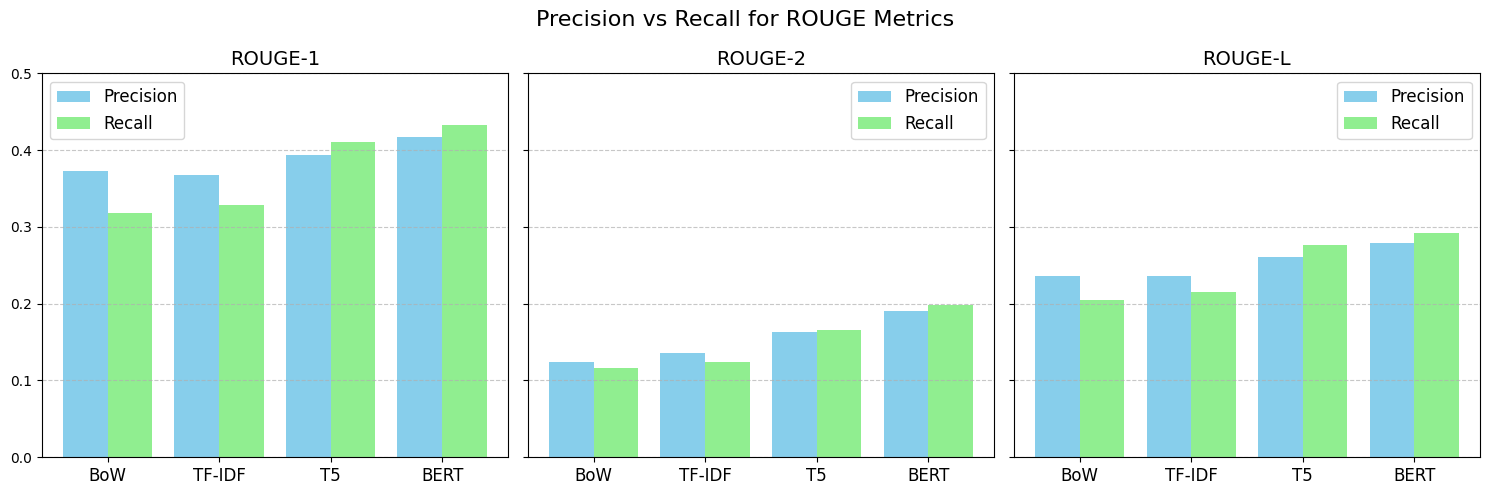

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['BoW', 'TF-IDF', 'T5', 'BERT']
precision = {
    'ROUGE-1': [avg_BoW_Rouge['ROUGE-1']['precision'], avg_TFIDF_Rouge['ROUGE-1']['precision'], avg_T5_rouge['ROUGE-1']['precision'], avg_BERT_rouge['ROUGE-1']['precision']],
    'ROUGE-2': [avg_BoW_Rouge['ROUGE-2']['precision'], avg_TFIDF_Rouge['ROUGE-2']['precision'], avg_T5_rouge['ROUGE-2']['precision'], avg_BERT_rouge['ROUGE-2']['precision']],
    'ROUGE-L': [avg_BoW_Rouge['ROUGE-L']['precision'], avg_TFIDF_Rouge['ROUGE-L']['precision'], avg_T5_rouge['ROUGE-L']['precision'], avg_BERT_rouge['ROUGE-L']['precision']]
}
recall = {
    'ROUGE-1': [avg_BoW_Rouge['ROUGE-1']['recall'], avg_TFIDF_Rouge['ROUGE-1']['recall'], avg_T5_rouge['ROUGE-1']['recall'], avg_BERT_rouge['ROUGE-1']['recall']],
    'ROUGE-2': [avg_BoW_Rouge['ROUGE-2']['recall'], avg_TFIDF_Rouge['ROUGE-2']['recall'], avg_T5_rouge['ROUGE-2']['recall'], avg_BERT_rouge['ROUGE-2']['recall']],
    'ROUGE-L': [avg_BoW_Rouge['ROUGE-L']['recall'], avg_TFIDF_Rouge['ROUGE-L']['recall'], avg_T5_rouge['ROUGE-L']['recall'], avg_BERT_rouge['ROUGE-L']['recall']]
}

metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, metric in enumerate(metrics):
    ax = axes[i]
    x = np.arange(len(models))
    ax.bar(x - 0.2, precision[metric], width=0.4, label='Precision', color='skyblue')
    ax.bar(x + 0.2, recall[metric], width=0.4, label='Recall', color='lightgreen')
    ax.set_title(metric, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=12)
    ax.set_ylim(0, 0.5)
    ax.legend(fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

fig.suptitle('Precision vs Recall for ROUGE Metrics', fontsize=16)
plt.tight_layout()
plt.show()